In [17]:
import pandas as pd
import numpy as np
import re
import geopy
from geopy.distance import vincenty
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# 1. Trips 

## 1.1  handle the trips data for specific route

In [18]:
i = "145"
# Change csv file for specific route
filename = "trips_routes/trips_" + i + ".txt"
trips = pd.read_csv(filename, sep=';',names = ["datasource","dayofservice","tripid","lineid","routeid","direction","plannedtime_arr","plannedtime_dep","actualtime_arr","actualtime_dep","basin","tenderlot","suppressed","justificationid","lastupdate","note"])
trips.head()

,datasource,dayofservice,tripid,lineid,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,basin,tenderlot,suppressed,justificationid,lastupdate,note
0,DB,09-FEB-16 00:00:00,2824642,145,145_105,2,45668,40800,45375.0,40782.0,BasDef,NaN,NaN,NaN,12-APR-16 09:35:20,",2426901,"
1,DB,08-APR-16 00:00:00,3010920,145,145_102,1,36753,31800,36610.0,31838.0,BasDef,NaN,NaN,NaN,06-MAY-16 09:25:16,",2413010,"
2,DB,02-APR-16 00:00:00,2902410,145,145_105,2,70381,65700,70340.0,65664.0,BasDef,NaN,NaN,NaN,28-APR-16 11:33:30,",2427156,2427156,"
3,DB,02-APR-16 00:00:00,2909769,145,145_102,1,43017,38700,44054.0,39131.0,BasDef,NaN,NaN,NaN,28-APR-16 11:33:30,",2422875,"
4,DB,02-APR-16 00:00:00,2909770,145,145_105,2,49355,44100,49585.0,44314.0,BasDef,NaN,NaN,NaN,28-APR-16 11:33:30,",2422876,"


In [19]:
trips.shape

(59675, 16)

## 1.2  preprocessing the trips table

In [20]:
# Drop duplicates
trips = trips.drop_duplicates()

In [21]:
# Convert day of service to date time
trips['dayofservice'] = pd.to_datetime(trips['dayofservice'])

In [22]:
# The lineid of trips are all specific route, So could be dropped.
trips = trips.drop(['lineid','datasource','basin','tenderlot','lastupdate','note'], axis=1)

In [23]:
#rename the tripid to tripID which enable merging the two tables
trips.rename(columns ={'tripid':"tripID"},inplace = True )

In [24]:
trips.head()

,dayofservice,tripID,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,suppressed,justificationid
0,2016-02-09,2824642,145_105,2,45668,40800,45375.0,40782.0,NaN,NaN
1,2016-04-08,3010920,145_102,1,36753,31800,36610.0,31838.0,NaN,NaN
2,2016-04-02,2902410,145_105,2,70381,65700,70340.0,65664.0,NaN,NaN
3,2016-04-02,2909769,145_102,1,43017,38700,44054.0,39131.0,NaN,NaN
4,2016-04-02,2909770,145_105,2,49355,44100,49585.0,44314.0,NaN,NaN


In [25]:
trips.notnull().mean()

dayofservice       1.000000
tripID             1.000000
routeid            1.000000
direction          1.000000
plannedtime_arr    1.000000
plannedtime_dep    1.000000
actualtime_arr     0.943745
actualtime_dep     0.930792
suppressed         0.003486
justificationid    0.003486
dtype: float64

In [26]:
trips = trips[trips['suppressed'].isnull() & trips['justificationid'].isnull()]

In [27]:
trips.notnull().mean()

dayofservice       1.000000
tripID             1.000000
routeid            1.000000
direction          1.000000
plannedtime_arr    1.000000
plannedtime_dep    1.000000
actualtime_arr     0.944978
actualtime_dep     0.931895
suppressed         0.000000
justificationid    0.000000
dtype: float64

# 2. Leavetimes_distance 

In [28]:
filename = "trips_leavetimes/trips_leavetimes_" + i + ".txt"
leavetimes = pd.read_csv(filename, sep=';',names = ["datasource","dayofservice","tripID","progrnumber","stoppointid","plannedtime_arr_stop","plannedtime_dep_stop","actualtime_arr_stop","actualtime_dep_stop","vehicleid","passengers","passengersin","passengersout","distance","suppressed_stop","justificationid_stop","lastupdate","note"])
leavetimes.head()

,datasource,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,vehicleid,passengers,passengersin,passengersout,distance,suppressed_stop,justificationid_stop,lastupdate,note
0,DB,31-MAR-16 00:00:00,2896014,66,4175,65040,65040,64992,65004,1000582,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
1,DB,31-MAR-16 00:00:00,2896015,53,773,69003,69003,68981,69009,1000582,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
2,DB,31-MAR-16 00:00:00,2896015,58,906,69300,69300,69244,69273,1000582,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
3,DB,31-MAR-16 00:00:00,2896015,63,792,69732,69732,69749,69796,1000582,NaN,NaN,NaN,NaN,NaN,NaN,28-APR-16 07:56:40,NaN
4,DB,29-FEB-16 00:00:00,2890938,13,847,42858,42858,42928,42956,1930279,NaN,NaN,NaN,NaN,NaN,NaN,27-APR-16 20:38:10,NaN


In [29]:
# The lineid of trips are all specific route, So could be dropped.
leavetimes = leavetimes.drop(['datasource','vehicleid','passengers','passengersin','passengersout','distance','lastupdate','note'], axis=1)

In [30]:
leavetimes = leavetimes.drop_duplicates()

In [31]:
leavetimes['dayofservice'] = pd.to_datetime(leavetimes['dayofservice'])

In [32]:
leavetimes.shape

(3000058, 10)

In [33]:
leavetimes.head()

,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,suppressed_stop,justificationid_stop
0,2016-03-31,2896014,66,4175,65040,65040,64992,65004,NaN,NaN
1,2016-03-31,2896015,53,773,69003,69003,68981,69009,NaN,NaN
2,2016-03-31,2896015,58,906,69300,69300,69244,69273,NaN,NaN
3,2016-03-31,2896015,63,792,69732,69732,69749,69796,NaN,NaN
4,2016-02-29,2890938,13,847,42858,42858,42928,42956,NaN,NaN


In [34]:
leavetimes.notnull().mean()

dayofservice            1.000000
tripID                  1.000000
progrnumber             1.000000
stoppointid             1.000000
plannedtime_arr_stop    1.000000
plannedtime_dep_stop    1.000000
actualtime_arr_stop     1.000000
actualtime_dep_stop     1.000000
suppressed_stop         0.018599
justificationid_stop    0.018599
dtype: float64

In [35]:
# only keep rows whose suppressed_stop and justificationid_stop are NAN
# After the last operation, drop these two columns.
leavetimes = leavetimes[leavetimes['suppressed_stop'].isnull() & leavetimes['justificationid_stop'].isnull()]
leavetimes = leavetimes.drop(['suppressed_stop','justificationid_stop'],axis = 1)

# 3. Merge the leavetimes and trips table together

In [36]:
final = pd.merge(leavetimes, trips, on=['tripID','dayofservice'])

In [37]:
final.head()

,dayofservice,tripID,progrnumber,stoppointid,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,suppressed,justificationid
0,2016-03-31,2896014,66,4175,65040,65040,64992,65004,145_102,1,65290,59400,65117.0,59345.0,NaN,NaN
1,2016-03-31,2896014,1,4320,59400,59400,59345,59345,145_102,1,65290,59400,65117.0,59345.0,NaN,NaN
2,2016-03-31,2896014,2,1476,59584,59584,59582,59582,145_102,1,65290,59400,65117.0,59345.0,NaN,NaN
3,2016-03-31,2896014,3,1477,59759,59759,59676,59676,145_102,1,65290,59400,65117.0,59345.0,NaN,NaN
4,2016-03-31,2896014,4,1478,59818,59818,59726,59726,145_102,1,65290,59400,65117.0,59345.0,NaN,NaN


Check quality of columns

In [38]:
# Convert date time to timestamp
final['dayofservice_new'] = final.dayofservice.values.astype(np.int64) // 10 ** 9

In [39]:
final.rename(columns={"stoppointid":"stop_id"},inplace = True )

In [40]:
final.notnull().mean()

dayofservice            1.000000
tripID                  1.000000
progrnumber             1.000000
stop_id                 1.000000
plannedtime_arr_stop    1.000000
plannedtime_dep_stop    1.000000
actualtime_arr_stop     1.000000
actualtime_dep_stop     1.000000
routeid                 1.000000
direction               1.000000
plannedtime_arr         1.000000
plannedtime_dep         1.000000
actualtime_arr          0.970671
actualtime_dep          0.955221
suppressed              0.000000
justificationid         0.000000
dayofservice_new        1.000000
dtype: float64

In [41]:
# alse drip the suppressed and justificationid
final = final.drop(['suppressed','justificationid'],axis =1)
final = final.dropna(how='any')
final.shape

(2707555, 15)

In [42]:
final.notnull().mean()

dayofservice            1.0
tripID                  1.0
progrnumber             1.0
stop_id                 1.0
plannedtime_arr_stop    1.0
plannedtime_dep_stop    1.0
actualtime_arr_stop     1.0
actualtime_dep_stop     1.0
routeid                 1.0
direction               1.0
plannedtime_arr         1.0
plannedtime_dep         1.0
actualtime_arr          1.0
actualtime_dep          1.0
dayofservice_new        1.0
dtype: float64

# 4. Bus Stops & Weather Stations

## 4.1 Clean table

In [43]:
weatherstation = pd.read_csv("bus_stops-stations.csv", sep=',')
weatherstation.head()

,stop_id,stop_name,stop_lat,stop_lon,stationid
0,7612,Davenport Hotel Merrion Street,53.341347,-6.250529,1
1,2,"Rotunda, Parnell Square West",53.352244,-6.263723,1
2,3,"Rotunda, Granby Place",53.352309,-6.263811,1
3,4,"Rotunda, Rotunda Hospital",53.352575,-6.264175,1
4,6,"Rotunda, Saint Martin's Chapel",53.352749,-6.264454,1


In [44]:
weatherstation.dtypes

stop_id        int64
stop_name     object
stop_lat     float64
stop_lon     float64
stationid      int64
dtype: object

In [45]:
# Stop_name, stop_lat and stop_lon are useless, So drop them.
weatherstation = weatherstation.drop(['stop_name','stop_lat','stop_lon'], axis=1)

In [46]:
weatherstation.head()

,stop_id,stationid
0,7612,1
1,2,1
2,3,1
3,4,1
4,6,1


## 4.2 Merge with main table

In [47]:
final = pd.merge(final, weatherstation, on=['stop_id'])

In [48]:
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,dayofservice_new,stationid
0,2016-03-31,2896014,66,4175,65040,65040,64992,65004,145_102,1,65290,59400,65117.0,59345.0,1459382400,2
1,2016-02-29,2890938,66,4175,46134,46134,46475,46492,145_102,1,46316,41400,46620.0,41486.0,1456704000,2
2,2016-02-29,2878265,66,4175,49734,49734,49795,49795,145_102,1,49916,45000,49895.0,45009.0,1456704000,2
3,2016-02-29,2885966,66,4175,44934,44934,44937,44950,145_102,1,45116,40200,45065.0,40214.0,1456704000,2
4,2016-02-29,2888124,66,4175,47334,47334,47484,47484,145_102,1,47516,42600,47602.0,42581.0,1456704000,2


In [49]:
final.notnull().mean()

dayofservice            1.0
tripID                  1.0
progrnumber             1.0
stop_id                 1.0
plannedtime_arr_stop    1.0
plannedtime_dep_stop    1.0
actualtime_arr_stop     1.0
actualtime_dep_stop     1.0
routeid                 1.0
direction               1.0
plannedtime_arr         1.0
plannedtime_dep         1.0
actualtime_arr          1.0
actualtime_dep          1.0
dayofservice_new        1.0
stationid               1.0
dtype: float64

# 5. Weather

In [50]:
weather = pd.read_csv("weather.csv", sep=',')
weather.head()

,date,rain,temp,wdsp,stationid
0,1451606400,0.0,1.9,8.0,1
1,1451610000,0.0,1.6,7.0,1
2,1451613600,0.0,0.7,6.0,1
3,1451617200,0.0,0.8,6.0,1
4,1451620800,0.0,2.9,5.0,1


## 5.1 Update dates and times to merge with main table

In [51]:
# USE plannedtime of arrival on each stop to catlogival the time of arrival
final["timeofarrival"] = final["dayofservice_new"] + final["plannedtime_arr_stop"]
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,plannedtime_arr,plannedtime_dep,actualtime_arr,actualtime_dep,dayofservice_new,stationid,timeofarrival
0,2016-03-31,2896014,66,4175,65040,65040,64992,65004,145_102,1,65290,59400,65117.0,59345.0,1459382400,2,1459447440
1,2016-02-29,2890938,66,4175,46134,46134,46475,46492,145_102,1,46316,41400,46620.0,41486.0,1456704000,2,1456750134
2,2016-02-29,2878265,66,4175,49734,49734,49795,49795,145_102,1,49916,45000,49895.0,45009.0,1456704000,2,1456753734
3,2016-02-29,2885966,66,4175,44934,44934,44937,44950,145_102,1,45116,40200,45065.0,40214.0,1456704000,2,1456748934
4,2016-02-29,2888124,66,4175,47334,47334,47484,47484,145_102,1,47516,42600,47602.0,42581.0,1456704000,2,1456751334


In [52]:
final['timeofarrival']=pd.to_datetime(final['timeofarrival'],unit='s')
final["date"] = pd.DatetimeIndex(final['timeofarrival']).round('H').values.astype(np.int64) // 10 ** 9
final["year"] = pd.DatetimeIndex(final['timeofarrival']).year
final["month"] = pd.DatetimeIndex(final['timeofarrival']).month
final["hour"] = pd.DatetimeIndex(final['timeofarrival']).hour
final["weekday"] = pd.DatetimeIndex(final['timeofarrival']).weekday
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,...,actualtime_arr,actualtime_dep,dayofservice_new,stationid,timeofarrival,date,year,month,hour,weekday
0,2016-03-31,2896014,66,4175,65040,65040,64992,65004,145_102,1,...,65117.0,59345.0,1459382400,2,2016-03-31 18:04:00,1459447200,2016,3,18,3
1,2016-02-29,2890938,66,4175,46134,46134,46475,46492,145_102,1,...,46620.0,41486.0,1456704000,2,2016-02-29 12:48:54,1456750800,2016,2,12,0
2,2016-02-29,2878265,66,4175,49734,49734,49795,49795,145_102,1,...,49895.0,45009.0,1456704000,2,2016-02-29 13:48:54,1456754400,2016,2,13,0
3,2016-02-29,2885966,66,4175,44934,44934,44937,44950,145_102,1,...,45065.0,40214.0,1456704000,2,2016-02-29 12:28:54,1456747200,2016,2,12,0
4,2016-02-29,2888124,66,4175,47334,47334,47484,47484,145_102,1,...,47602.0,42581.0,1456704000,2,2016-02-29 13:08:54,1456750800,2016,2,13,0


In [53]:
final = pd.merge(final, weather, on=['date','stationid'])
final.head()

,dayofservice,tripID,progrnumber,stop_id,plannedtime_arr_stop,plannedtime_dep_stop,actualtime_arr_stop,actualtime_dep_stop,routeid,direction,...,stationid,timeofarrival,date,year,month,hour,weekday,rain,temp,wdsp
0,2016-03-31,2896014,66,4175,65040,65040,64992,65004,145_102,1,...,2,2016-03-31 18:04:00,1459447200,2016,3,18,3,0.0,9.1,7.0
1,2016-03-31,2899854,66,4175,65373,65373,64321,64325,145_102,1,...,2,2016-03-31 18:09:33,1459447200,2016,3,18,3,0.0,9.1,7.0
2,2016-03-31,2895648,66,4175,64773,64773,64600,64617,145_102,1,...,2,2016-03-31 17:59:33,1459447200,2016,3,17,3,0.0,9.1,7.0
3,2016-03-31,2906131,66,4175,63240,63240,63330,63341,145_102,1,...,2,2016-03-31 17:34:00,1459447200,2016,3,17,3,0.0,9.1,7.0
4,2016-03-31,2902616,44,4175,66132,66132,66231,66241,145_99,1,...,2,2016-03-31 18:22:12,1459447200,2016,3,18,3,0.0,9.1,7.0


In [54]:
final.shape

(2691869, 25)

# 5. drop the useless table

## 5.1  drop bank holidays and avoid their influence to time table. 

In [55]:
# create a dataframe to store the date of bankholiday
# Deleted bank holidays from final table
bankHolidays =["2016-01-01","2016-03-17","2016-03-25","2016-03-28","2016-05-02","2016-06-06","2016-08-01","2016-10-31","2016-12-25","2016-12-26","2016-12-27","2016-12-28","2017-01-01","2017-01-02","2017-03-17","2017-04-14","2017-04-17","2017-05-01","2017-06-05","2017-08-07","2017-10-30","2017-12-25","2017-12-26","2017-12-27"]

final = final.loc[~ final["dayofservice"].isin(bankHolidays)]

In [56]:
final.shape

(2648056, 25)

## 5.2 Test and drop the routeid

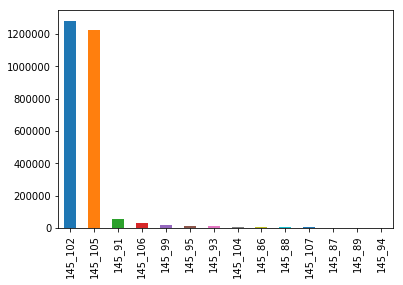

In [57]:
final.routeid.value_counts().plot(kind='bar')

In [58]:
final['routeid'].value_counts(normalize = True)

145_102    0.484537
145_105    0.462149
145_91     0.020925
145_106    0.010409
145_99     0.006688
145_95     0.004326
145_93     0.003250
145_104    0.002479
145_86     0.001659
145_88     0.001656
145_107    0.001249
145_87     0.000361
145_89     0.000290
145_94     0.000022
Name: routeid, dtype: float64

In [59]:
final['weekday'].value_counts(normalize = True)

1    0.186633
2    0.181391
3    0.163627
0    0.160324
4    0.150696
5    0.088696
6    0.068633
Name: weekday, dtype: float64

In [60]:
# routes = final.routeid.value_counts()[0:2].index.tolist()
# print(routes)
# final = final[final.routeid.isin(routes)]
# final.routeid.unique()

In [61]:
# final.head()

## 5.3  Only keep the summer table

In [62]:
final.month.unique()

array([3, 2, 4, 5, 6, 1, 7], dtype=int64)

In [63]:
final.direction.unique()

array([1, 2], dtype=int64)

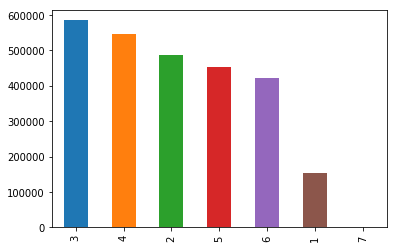

In [64]:
final.month.value_counts().plot(kind='bar')

In [65]:
final['month'].value_counts(normalize = True)

3    0.220848
4    0.205860
2    0.184358
5    0.171223
6    0.159625
1    0.058059
7    0.000028
Name: month, dtype: float64

In [66]:
final = final.loc[final["month"].isin([6,7])]

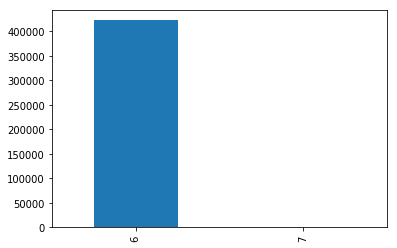

In [67]:
final.month.value_counts().plot(kind='bar')

In [68]:
final['month'].value_counts(normalize = True)

6    0.999825
7    0.000175
Name: month, dtype: float64

In [69]:
final.shape

(422771, 25)

## 5.4 Drop the year and month

In [70]:
# Do not need year, drop it
final = final.drop(['year','month'], axis=1)

In [71]:
final.dtypes

dayofservice            datetime64[ns]
tripID                           int64
progrnumber                      int64
stop_id                          int64
plannedtime_arr_stop             int64
plannedtime_dep_stop             int64
actualtime_arr_stop              int64
actualtime_dep_stop              int64
routeid                         object
direction                        int64
plannedtime_arr                  int64
plannedtime_dep                  int64
actualtime_arr                 float64
actualtime_dep                 float64
dayofservice_new                 int64
stationid                        int64
timeofarrival           datetime64[ns]
date                             int64
hour                             int64
weekday                          int64
rain                           float64
temp                           float64
wdsp                           float64
dtype: object

## 5.5 Test the final stop relation with headsign

In [72]:
def get_destinationstop(group):
    group.sort_values(['progrnumber'],ascending=False)
    max_sequence_row = group.ix[group['progrnumber'].idxmax()]
    group["route_end_stop"] = max_sequence_row.stop_id
    return group
def get_departurestop(group):
    group.sort_values(['progrnumber'],ascending=True)
    max_sequence_row = group.ix[group['progrnumber'].idxmin()]
    group["route_start_stop"] = max_sequence_row.stop_id
    return group

In [73]:
final = final.groupby(["dayofservice","tripID"]).apply(get_destinationstop)
final = final.groupby(["dayofservice","tripID"]).apply(get_departurestop)

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [74]:
timetable = pd.read_csv("timetable.csv",dtype = {"line_ID": object})

In [75]:
timetable.columns[7]

'stop_id'

In [76]:
timetable_1 = timetable[timetable["line_ID"] == i]
timetable_1 

,trip_id,departure_time,stop_headsign,prog_number,shape_dist_traveled,hour,distance,stop_id,line_ID,shape_id,weekday,previous_stopID,route_end_stop,route_start_stop,route_start_time,route_end_time
151734,2186.y102m.60-145-d12-1.466.I,60300,Heuston Station,1,0.000000,16,328.043455,768,145,60-145-d12-1.466.I,y102m,NaN,4320,768,60300,62880
151735,2186.y102m.60-145-d12-1.466.I,60420,Heuston Station,2,328.043455,16,443.918421,769,145,60-145-d12-1.466.I,y102m,768.0,4320,768,60300,62880
151736,2186.y102m.60-145-d12-1.466.I,60500,Heuston Station,3,771.961876,16,191.198022,770,145,60-145-d12-1.466.I,y102m,769.0,4320,768,60300,62880
151737,2186.y102m.60-145-d12-1.466.I,60533,Heuston Station,4,963.159898,16,507.040131,771,145,60-145-d12-1.466.I,y102m,770.0,4320,768,60300,62880
151738,2186.y102m.60-145-d12-1.466.I,60600,Heuston Station,5,1470.200029,16,1307.370769,772,145,60-145-d12-1.466.I,y102m,771.0,4320,768,60300,62880
151739,2186.y102m.60-145-d12-1.466.I,60648,Heuston Station,6,2777.570798,16,242.330353,773,145,60-145-d12-1.466.I,y102m,772.0,4320,768,60300,62880
151740,2186.y102m.60-145-d12-1.466.I,60704,Heuston Station,7,3019.901151,16,324.555413,774,145,60-145-d12-1.466.I,y102m,773.0,4320,768,60300,62880
151741,2186.y102m.60-145-d12-1.466.I,60780,Heuston Station,8,3344.456565,16,283.388223,775,145,60-145-d12-1.466.I,y102m,774.0,4320,768,60300,62880
151742,2186.y102m.60-145-d12-1.466.I,60840,Heuston Station,9,3627.844787,16,208.700743,776,145,60-145-d12-1.466.I,y102m,775.0,4320,768,60300,62880
151743,2186.y102m.60-145-d12-1.466.I,60907,Heuston Station,10,3836.545530,16,341.507347,777,145,60-145-d12-1.466.I,y102m,776.0,4320,768,60300,62880


In [77]:
timetable_stop_1 = timetable_1[["route_end_stop","route_start_stop"]].drop_duplicates()
timetable_stop_1

,route_end_stop,route_start_stop
151734,4320,768
151834,4320,773
151854,4320,4151
151917,4320,2060
151955,4320,4202
152411,4320,4533
152484,4132,4320
152543,763,4320
152658,6000,767
152846,7574,4320


In [78]:
final.shape

(422771, 25)

In [79]:
final = pd.merge(final,timetable_stop_1, on = ["route_end_stop","route_start_stop"] ,how ="inner" )

In [80]:
final.shape

(408593, 25)

In [81]:
113675/124402

0.9137714827735889

In [82]:
final["route_end_stop"].unique()

array([7574, 4320, 6000,  325,  763, 4132], dtype=int64)

In [83]:
final["route_start_stop"].value_counts(normalize = True)

4320    0.487886
7574    0.482546
4202    0.014303
767     0.003884
760     0.003500
4533    0.003025
3143    0.001527
334     0.001378
768     0.000656
4151    0.000605
773     0.000602
2060    0.000088
Name: route_start_stop, dtype: float64

In [84]:
final["route_end_stop"].value_counts(normalize = True)

4320    0.492480
7574    0.490048
325     0.010871
6000    0.003884
763     0.002570
4132    0.000147
Name: route_end_stop, dtype: float64

In [85]:
final["stop_sequence_max"] = final.groupby(["dayofservice","tripID"]).progrnumber.transform(max)
final["stop_sequence_max"].unique()

array([69, 70, 72, 57, 50, 51, 47, 48, 67, 73, 63, 23, 20, 25, 60, 38],
      dtype=int64)

In [86]:
final["stop_sequence_min"] = final.groupby(["dayofservice","tripID"]).progrnumber.transform(min)
final["stop_sequence_min"].unique()

array([ 1, 16, 20,  7, 53, 25], dtype=int64)

In [87]:
final = final[final["stop_sequence_min"] == 1]

In [88]:
final["stop_sequence_max"].value_counts(normalize = True)

72    0.473741
69    0.349152
70    0.138143
57    0.014183
67    0.010919
73    0.003038
47    0.002753
23    0.002581
48    0.001148
50    0.001106
51    0.000966
63    0.000917
25    0.000659
20    0.000457
60    0.000147
38    0.000088
Name: stop_sequence_max, dtype: float64

In [89]:
final["stop_sequence_min"].value_counts(normalize = True)

1    1.0
Name: stop_sequence_min, dtype: float64

# 6. Final table clean up

## 6.1 Target Feature

In [90]:
#get rid of the timeofarrival which is the medium valibles of the table
final = final.drop(['timeofarrival','date'], axis=1)

In [91]:
final['target'] = final['actualtime_arr_stop'] - final['plannedtime_dep']

In [92]:
final.dtypes

dayofservice            datetime64[ns]
tripID                           int64
progrnumber                      int64
stop_id                          int64
plannedtime_arr_stop             int64
plannedtime_dep_stop             int64
actualtime_arr_stop              int64
actualtime_dep_stop              int64
routeid                         object
direction                        int64
plannedtime_arr                  int64
plannedtime_dep                  int64
actualtime_arr                 float64
actualtime_dep                 float64
dayofservice_new                 int64
stationid                        int64
hour                             int64
weekday                          int64
rain                           float64
temp                           float64
wdsp                           float64
route_end_stop                   int64
route_start_stop                 int64
stop_sequence_max                int64
stop_sequence_min                int64
target                   

In [93]:
dataForModel =  final[["progrnumber","weekday","hour",'rain',"temp","wdsp","target","route_start_stop","route_end_stop"]]
dataForModel['stopID'] =  final[['stop_id']]

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [94]:
dataForModel.dtypes

progrnumber           int64
weekday               int64
hour                  int64
rain                float64
temp                float64
wdsp                float64
target                int64
route_start_stop      int64
route_end_stop        int64
stopID                int64
dtype: object

In [95]:
dataForModels = pd.get_dummies(data=dataForModel, columns=['stopID','progrnumber','weekday','hour',"route_start_stop","route_end_stop"])

In [96]:
# dataForModels[(dataForModels["stopID_265"] == 1) & (dataForModels["route_end_stop_380"] == 1) & (dataForModels["route_start_stop_265"] == 1)]

## 7.1 train models for specific route

In [97]:
# # Change csv file for specific route
# final.to_csv("final_route_145.csv",index=False)
# dataForModel.to_csv("model.csv", index =False)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#normalized_sparsedf = preprocessing.normalize(dataForModel)
scaler= StandardScaler().fit(dataForModels)
normalized_sparsed = scaler.transform(dataForModels)

In [98]:
normalized_sparsed

array([[-0.22228845, -0.42411216, -1.03978599, ..., -0.9856515 ,
        -0.06258077,  1.02086355],
       [-0.22228845, -0.42411216, -1.03978599, ..., -0.9856515 ,
        -0.06258077,  1.02086355],
       [-0.22228845, -0.42411216, -1.03978599, ..., -0.9856515 ,
        -0.06258077,  1.02086355],
       ...,
       [-0.02482196,  0.22731277,  0.26811584, ...,  1.01455738,
        -0.06258077, -0.97956284],
       [-0.02482196,  0.22731277,  0.26811584, ...,  1.01455738,
        -0.06258077, -0.97956284],
       [-0.02482196,  0.22731277,  0.26811584, ...,  1.01455738,
        -0.06258077, -0.97956284]])

In [99]:
DF = pd.DataFrame(normalized_sparsed, columns=dataForModels.columns,index= dataForModels.index)

In [100]:
DF.sample(10)

,rain,temp,wdsp,target,stopID_315,stopID_325,stopID_334,stopID_345,stopID_406,stopID_435,...,route_start_stop_4202,route_start_stop_4320,route_start_stop_4533,route_start_stop_7574,route_end_stop_325,route_end_stop_763,route_end_stop_4132,route_end_stop_4320,route_end_stop_6000,route_end_stop_7574
65791,-0.222288,-0.869824,-0.516625,-1.620199,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,1.020156,-0.055204,-0.969776,-0.10507,-0.05087,-0.012145,-0.985652,-0.062581,1.020864
18191,-0.024822,-0.629825,-0.778206,2.018102,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,1.020156,-0.055204,-0.969776,-0.10507,-0.05087,-0.012145,-0.985652,-0.062581,1.020864
320493,-0.222288,0.433026,-2.086107,0.648745,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,-0.980242,-0.055204,1.031166,-0.10507,-0.05087,-0.012145,1.014557,-0.062581,-0.979563
317857,-0.024822,0.261598,-1.562947,0.261633,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,-0.980242,-0.055204,1.031166,-0.10507,-0.05087,-0.012145,1.014557,-0.062581,-0.979563
332599,-0.222288,-0.012686,-0.516625,2.113158,-0.072017,11.824288,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,-0.980242,-0.055204,1.031166,-0.10507,-0.05087,-0.012145,1.014557,-0.062581,-0.979563
52292,-0.222288,3.004440,-1.039786,1.059966,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,1.020156,-0.055204,-0.969776,-0.10507,-0.05087,-0.012145,-0.985652,-0.062581,1.020864
243877,0.962511,-1.144108,0.006535,-1.023689,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,-0.980242,-0.055204,1.031166,-0.10507,-0.05087,-0.012145,1.014557,-0.062581,-0.979563
270674,-0.222288,-0.938395,0.268116,-0.292860,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,-0.980242,-0.055204,1.031166,-0.10507,-0.05087,-0.012145,1.014557,-0.062581,-0.979563
88502,-0.024822,-0.389827,0.006535,-1.490703,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,1.020156,-0.055204,-0.969776,-0.10507,-0.05087,-0.012145,-0.985652,-0.062581,1.020864
216577,-0.222288,-0.766967,-0.516625,-0.949986,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,...,-0.119948,-0.980242,-0.055204,1.031166,-0.10507,-0.05087,-0.012145,1.014557,-0.062581,-0.979563


In [101]:
y = DF['target']

In [102]:
# keep the whole DF in x_train_y and X_test_y which are helpful to denormalize
X_train_y, X_test_y, y_train, y_test = train_test_split(DF,y,test_size = 0.3, random_state= 0 )
X_train = X_train_y.drop(['target'],axis=1)
X_test = X_test_y.drop(['target'],axis=1)

In [103]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(200,200,200), max_iter = 1000, solver='lbfgs', \
                   alpha=0.01, activation = 'tanh', random_state = 8)

In [104]:
mlp.fit(X_train,y_train)

MLPRegressor(activation='tanh', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(200, 200, 200), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=8, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [105]:
predictions = mlp.predict(X_test)

In [106]:
x_mini = X_test.iloc[0]

In [107]:
mlp.predict(X_test.head(1))

array([-0.68561135])

In [108]:
X_test.head(1)

,rain,temp,wdsp,stopID_315,stopID_325,stopID_334,stopID_345,stopID_406,stopID_435,stopID_461,...,route_start_stop_4202,route_start_stop_4320,route_start_stop_4533,route_start_stop_7574,route_end_stop_325,route_end_stop_763,route_end_stop_4132,route_end_stop_4320,route_end_stop_6000,route_end_stop_7574
99067,-0.222288,-0.081257,-0.255045,-0.072017,-0.084572,-0.085174,-0.084409,-0.08532,-0.085218,-0.084306,...,-0.119948,1.020156,-0.055204,-0.969776,-0.10507,-0.05087,-0.012145,-0.985652,-0.062581,1.020864


In [109]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.948519374497392

In [110]:
predictionsTestClass = pd.DataFrame({'Actual Delay': X_test_y.target, 'Prediction Delay': predictions})
predictionsTestClass.head(10)

,Actual Delay,Prediction Delay
99067,-0.631066,-0.685611
200224,-1.259951,-1.213910
146857,-1.281993,-1.319199
261143,-0.398248,0.002929
44181,2.157931,2.161695
173248,0.131448,0.424485
43409,0.486875,0.598208
249854,-1.402535,-1.384805
172619,0.067388,-0.311847
184102,0.728647,0.559596


In [111]:
X_test_y.target = predictions
prediction = scaler.inverse_transform(X_test_y)

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [112]:
X_test_y.target = y_test
actual = scaler.inverse_transform(X_test_y)

C:\Users\Di\Anaconda3\envs\bashi\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [113]:
DF_actual = pd.DataFrame(actual, columns=dataForModels.columns,index= X_test_y.index)
DF_prediction = pd.DataFrame(prediction, columns=dataForModels.columns,index= X_test_y.index)
predictionsTestClass = pd.DataFrame({'Actual': DF_actual.target, 'Prediction': DF_prediction.target})
predictionsTestClass.sample(10)

,Actual,Prediction
360688,3479.0,2872.534001
185854,1306.0,1382.871786
129304,1664.0,2271.105146
141171,3408.0,3453.829580
172694,2748.0,3028.627880
175553,2729.0,2849.264016
299192,2857.0,3282.326900
100206,2268.0,2158.168323
156360,117.0,137.844837
238172,239.0,333.819631


In [114]:
from itertools import groupby
def back_from_dummies(df):
    result_series = {}

    # Find dummy columns and build pairs (category, category_value)
    dummmy_tuples = [(col.split("_")[0],col) for col in df.columns if "_" in col]

    # Find non-dummy columns that do not have a _
    non_dummy_cols = [col for col in df.columns if "_" not in col]

    # For each category column group use idxmax to find the value.
    for dummy, cols in groupby(dummmy_tuples, lambda item: item[0]):

        #Select columns for each category
        dummy_df = df[[col[1] for col in cols]]

        # Find max value among columns
        max_columns = dummy_df.idxmax(axis=1)

        # Remove category_ prefix
        result_series[dummy] = max_columns.apply(lambda item: item.split("_")[1])

    # Copy non-dummy columns over.
    for col in non_dummy_cols:
        result_series[col] = df[col]

    # Return dataframe of the resulting series
    return pd.DataFrame(result_series)

In [115]:
back_actual = back_from_dummies(DF_actual)
back_prediction = back_from_dummies(DF_prediction)

In [116]:
back_actual["predicted_target"] = DF_prediction.target

In [117]:
back_actual[["progrnumber","target","predicted_target"]].sample(10)

,progrnumber,target,predicted_target
139181,6,366.0,475.227736
348052,25,1785.0,1671.338394
295747,61,3013.0,2757.795263
399265,21,1382.0,1228.176276
305274,64,3731.0,3774.008706
146722,30,5442.0,3042.363076
139742,16,2007.0,2087.013818
203140,2,170.0,170.259870
216722,22,1709.0,1415.949666
395234,54,4123.0,4229.774017


In [118]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(mean_absolute_error(DF_actual.target,DF_prediction.target))
print(r2_score(DF_actual.target,DF_prediction.target))
print(mean_squared_error(DF_actual.target,DF_prediction.target))

241.30821890845996
0.948519374497392
108632.94050122763


In [119]:
from sklearn.metrics import mean_squared_error
mean_squared_error(DF_actual.target,DF_prediction.target)

108632.94050122763

In [120]:
dataForModels

,rain,temp,wdsp,target,stopID_315,stopID_325,stopID_334,stopID_345,stopID_406,stopID_435,...,route_start_stop_4202,route_start_stop_4320,route_start_stop_4533,route_start_stop_7574,route_end_stop_325,route_end_stop_763,route_end_stop_4132,route_end_stop_4320,route_end_stop_6000,route_end_stop_7574
0,0.0,14.1,5.0,4600,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0.0,14.1,5.0,4807,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0.0,14.1,5.0,5030,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
3,0.0,14.1,5.0,5147,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
4,0.0,14.1,5.0,5263,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
5,0.0,14.1,5.0,4806,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
6,0.0,14.1,5.0,3582,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
7,0.0,14.1,5.0,3631,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
8,0.0,14.1,5.0,3793,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
9,0.0,14.1,5.0,3482,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [121]:
# For the linear regression
from sklearn import linear_model
y= dataForModels["target"]
X_train, X_test, y_train, y_test = train_test_split(dataForModels,y,test_size = 0.1, random_state= 0 )
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_test)
print(predictions)
print(r2_score(y_test,predictions))
print(mean_absolute_error(y_test,predictions))
print(mean_squared_error(y_test,predictions))

[1603.  690.  658. ... 2630. 2628.  364.]
1.0
6.262552705081612e-12
5.745258958678168e-23


In [122]:
X_train, X_test, y_train, y_test = train_test_split(dataForModels,y,test_size = 0.3, random_state= 0 )
lr = linear_model.LinearRegression()
lr.fit(X_train,y_train)
predictions = lr.predict(X_train)
print(predictions)
print(r2_score(y_train,predictions))
print(mean_absolute_error(y_train,predictions))
print(mean_squared_error(y_train,predictions))

[3885. 4802. 3063. ... 1900. 3442. 3597.]
1.0
5.311834510361587e-12
4.1541746226663994e-23


In [123]:
from sklearn.externals import joblib
modelname =  i + ".sav"
normname = "n"+ i +".sav"
joblib.dump(mlp,modelname)
joblib.dump(scaler, normname)

['n145.sav']

In [124]:
columnname = "c" +i +".sav"
dataForModels.head(1).to_csv(columnname,header=True, index=False,columns = dataForModels.columns)

In [125]:
dataForModels.head(1)

,rain,temp,wdsp,target,stopID_315,stopID_325,stopID_334,stopID_345,stopID_406,stopID_435,...,route_start_stop_4202,route_start_stop_4320,route_start_stop_4533,route_start_stop_7574,route_end_stop_325,route_end_stop_763,route_end_stop_4132,route_end_stop_4320,route_end_stop_6000,route_end_stop_7574
0,0.0,14.1,5.0,4600,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [126]:
dataForModels_1 = pd.read_csv(columnname)
dataForModels_1

,rain,temp,wdsp,target,stopID_315,stopID_325,stopID_334,stopID_345,stopID_406,stopID_435,...,route_start_stop_4202,route_start_stop_4320,route_start_stop_4533,route_start_stop_7574,route_end_stop_325,route_end_stop_763,route_end_stop_4132,route_end_stop_4320,route_end_stop_6000,route_end_stop_7574
0,0.0,14.1,5.0,4600,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


## 7.2 Use the model

In [127]:
i="1"
from sklearn.externals import joblib
modelname =  i + ".sav"
normname = "n"+ i +".sav"
columnname = "c" +i +".csv"
loaded_mlp = joblib.load(modelname)
loaded_scaler = joblib.load(normname)
columnsname = pd.read_csv(columnname).columns
print(loaded_mlp)

FileNotFoundError: File b'c1.csv' does not exist

In [ ]:
dataForModel.dtypes

In [ ]:
dataForModels.columns

In [ ]:
data_example = [{"stopID_265": 1,"progrnumber_22": 1, "rain":0,"temp":16.6,"weekday_2":2,"hour_15":1,"wdsp":0,"route_start_stop_226":1,"route_end_stop_380":1}]

In [ ]:
example = pd.DataFrame(data_example, columns= columnsname )
example = example.fillna(0)

In [ ]:
example

In [ ]:
DF_n = scaler.transform(example)
DF_n = pd.DataFrame(DF_n, columns = columnsname)
prediction =mlp. DF_n.drop["target"]

In [ ]:
normalized_sparsed = loaded_scaler.transform(example)

In [ ]:
DF = pd.DataFrame(normalized_sparsed, columns=columnsname)
DF

In [ ]:
X_example = DF.drop(["target"],axis = 1)
X_example

In [ ]:
target = loaded_mlp.predict(X_example)
target

In [ ]:
target = mlp.predict(X_example)

In [ ]:
target = mlp.predict(X_example)
target

In [ ]:
DF['target'] = target

In [ ]:
actual = loaded_scaler.inverse_transform(DF)
actual = pd.DataFrame(actual, columns=columnsname)
actual['target']